# EPICS4 PV access example

Outside of this Jupyter notebook
- start the GUI, which will start the P4P server
```bash
$ python scripts/devGui.py --ip <RFSOC_IP_ADDDRESS>
```

In [1]:
# setup the P4P client
# https://mdavidsaver.github.io/p4p/client.html#usage
import numpy as np
import time
import matplotlib.pyplot as plt
from p4p.client.thread import Context
print( Context.providers() )
ctxt = Context('pva')

['pva']


In [2]:
# Get the FPGA firmware Version
# https://github.com/slaclab/darpa-accel-llrf-phase-1p5/blob/main/firmware/targets/shared_version.mk#L2
hex(ctxt.get( 'rfsoc_ioc:Root:RFSoC:AxiSocCore:AxiVersion:FpgaVersion' ))

'0x1020000'

In [3]:
# Put/Get the debug scratch pad
# https://github.com/slaclab/surf/blob/master/python/surf/axi/_AxiVersion.py#L47
ctxt.put( 'rfsoc_ioc:Root:RFSoC:AxiSocCore:AxiVersion:ScratchPad', 0x12345678 )
hex(ctxt.get( 'rfsoc_ioc:Root:RFSoC:AxiSocCore:AxiVersion:ScratchPad' ))

'0x12345678'

In [4]:
# Get the UpTimeCnt (units of seconds) 
# https://github.com/slaclab/surf/blob/master/python/surf/axi/_AxiVersion.py#L58
ctxt.get( 'rfsoc_ioc:Root:RFSoC:AxiSocCore:AxiVersion:UpTimeCnt' )

6449

In [5]:
# Get the UpTime ('HH:MM:SS')
# https://github.com/slaclab/surf/blob/master/python/surf/axi/_AxiVersion.py#L80
ctxt.get( 'rfsoc_ioc:Root:RFSoC:AxiSocCore:AxiVersion:UpTime' )

'1:47:30'

In [6]:
# Get the GitHash
# https://github.com/slaclab/surf/blob/master/python/surf/axi/_AxiVersion.py#L179
ctxt.get( 'rfsoc_ioc:Root:RFSoC:AxiSocCore:AxiVersion:GitHash' )

'0x2bc87524b78981eca1e0b9c813433b0fe550783f'

In [7]:
# Function for Setting DAC NCO only (units of MHz)
def SetDacNco(ncoFreqMhz):
    # DAC is a "quad" tile, so only 1 NCO value to set in the RF Tile's RF block
    ctxt.put( 'rfsoc_ioc:Root:RFSoC:RfDataConverter:dacTile[1]:dacBlock[1]:ncoFrequency', ncoFreqMhz)

    # Wait for DSP Clock to be stable after changing NCO value
    while( ctxt.get( 'rfsoc_ioc:Root:RFSoC:AxiSocCore:AxiVersion:DspReset' )):
        time.sleep(0.01)
    
# Function for Setting ADC NCO only (units of MHz)
def SetAdcNco(ncoFreqMhz):
    # ADC is a "dual" tile, so only 2 NCO value (odd/even) to set in the RF Tile's RF block
    ctxt.put( 'rfsoc_ioc:Root:RFSoC:RfDataConverter:adcTile[1]:adcBlock[2]:ncoFrequency', ncoFreqMhz) # ncoPhaseMode=Odd
    ctxt.put( 'rfsoc_ioc:Root:RFSoC:RfDataConverter:adcTile[1]:adcBlock[3]:ncoFrequency', ncoFreqMhz) # ncoPhaseMode=Even

    # Wait for DSP Clock to be stable after changing NCO value
    while( ctxt.get( 'rfsoc_ioc:Root:RFSoC:AxiSocCore:AxiVersion:DspReset' )):
        time.sleep(0.01)

# Function to trigger the waveform ring buffers
def TrigRingBuffer():
    ctxt.put( 'rfsoc_ioc:Root:Waveform:Updated', 0)
    time.sleep(0.1)
    ctxt.put( 'rfsoc_ioc:Root:RFSoC:Application:SoftDacTrigRaw', 1)

    # Wait for Waveform
    while( ctxt.get( 'rfsoc_ioc:Root:Waveform:Updated') != True):
        time.sleep(0.01)

# Function to plot the ADC/DAC waveforms
def PlotWavform():
    fig, axs = plt.subplots(6)
    axs[0].plot(ctxt.get('rfsoc_ioc:Root:Waveform:Time'),ctxt.get('rfsoc_ioc:Root:Waveform:AdcI[0]'))
    axs[0].set_ylabel("ADC I") 
    axs[1].plot(ctxt.get('rfsoc_ioc:Root:Waveform:Time'),ctxt.get('rfsoc_ioc:Root:Waveform:AdcQ[0]'))
    axs[1].set_ylabel("ADC Q") 
    axs[2].plot(ctxt.get('rfsoc_ioc:Root:Waveform:Time'),ctxt.get('rfsoc_ioc:Root:Waveform:AdcMag[0]'))
    axs[2].set_ylabel("ADC Mag")  
    
    axs[3].plot(ctxt.get('rfsoc_ioc:Root:Waveform:Time'),ctxt.get('rfsoc_ioc:Root:Waveform:DacI[0]'))
    axs[3].set_ylabel("DAC I")
    axs[4].plot(ctxt.get('rfsoc_ioc:Root:Waveform:Time'),ctxt.get('rfsoc_ioc:Root:Waveform:DacQ[0]'))
    axs[4].set_ylabel("DAC Q") 
    axs[5].plot(ctxt.get('rfsoc_ioc:Root:Waveform:Time'),ctxt.get('rfsoc_ioc:Root:Waveform:DacMag[0]'))
    axs[5].set_ylabel("DAC Mag") 
    axs[5].set_xlabel("Time (ns)")
    
    [axs[i].grid() for i in range(5)]
    
# Function to trigger then plot waveforms
def TriggerThenPlotWavform():  
    TrigRingBuffer()
    PlotWavform()

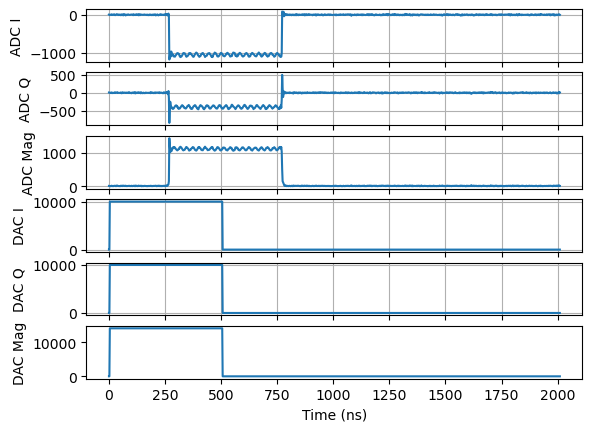

In [8]:
# Set both ADC and DAC to use a 1000 MHz NCO for digital RF mixing
SetAdcNco(ncoFreqMhz=1000.0)
SetDacNco(ncoFreqMhz=1000.0)

# Then trigger then plot waveforms
TriggerThenPlotWavform()